In [1]:
import pandas as pd
import numpy as np

EEG_data = []
Labels = []

for i in range(22):
    try:
        file_path = f"_DATA/eeg_data/{i+1:02}_thinking.csv"
        data = pd.read_csv(file_path)
        
        grouped = data.groupby('Epoch')
        
        subject_EEG = []
        subject_Labels = []
        for name, group in grouped:
            EEG_signals = group.iloc[:, 2:16].values
            label = group.iloc[0, 16]
            subject_EEG.append(EEG_signals)
            subject_Labels.append(label)
        
        EEG_data.append(np.array(subject_EEG))
        Labels.append(np.array(subject_Labels))

    except FileNotFoundError:
        print(f"{i+1:02} 번 파일이 존재하지 않습니다.")
        continue

all_EEG_data = np.vstack(EEG_data)
all_Labels = np.hstack(Labels)


unique_labels = np.unique(all_Labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}


05 번 파일이 존재하지 않습니다.
12 번 파일이 존재하지 않습니다.
22 번 파일이 존재하지 않습니다.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Band-Pass Filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Common Average Referencing (CAR) function
def apply_car(data):
    mean_signal = np.mean(data, axis=0)
    return data - mean_signal

# Step 1: Data Preprocessing (Exclude first 200 time points, apply Band-Pass Filtering + CAR)
def preprocess_data(eeg_data, fs=256, lowcut=0.5, highcut=45):
    print("Data preprocessing (excluding first 200 time points, Band-Pass Filtering + CAR)...")
    preprocessed_data = []
    for epoch in eeg_data:
        trimmed_epoch = epoch[200:]  # Exclude first 200 time points
        filtered_epoch = np.array([bandpass_filter(channel, lowcut, highcut, fs) for channel in trimmed_epoch.T]).T
        car_epoch = apply_car(filtered_epoch)
        preprocessed_data.append(car_epoch)
    print("Data preprocessing complete!")
    return np.array(preprocessed_data)

# Step 2: Feature Extraction
def extract_features(eeg_data):
    print("Extracting features...")
    features = []
    for epoch in eeg_data:
        epoch_features = []
        for channel in epoch.T:
            epoch_features.extend([np.mean(channel), np.std(channel), np.min(channel), np.max(channel)])
        features.append(epoch_features)
    print("Feature extraction complete!")
    return np.array(features)


In [5]:

# Preprocess EEG data and extract features
print("Encoding EEG data and labels...")
filtered_EEG_data = preprocess_data(all_EEG_data, fs=256, lowcut=0.5, highcut=45)
flattened_EEG_data = np.array([epoch.reshape(-1) for epoch in filtered_EEG_data])
flattened_Labels = np.array([label_to_int[label] for label in all_Labels])
print("Data flattening and label encoding complete!")

Encoding EEG data and labels...
Data preprocessing (excluding first 200 time points, Band-Pass Filtering + CAR)...
Data preprocessing complete!
Data flattening and label encoding complete!


Extracting features...
Feature extraction complete!


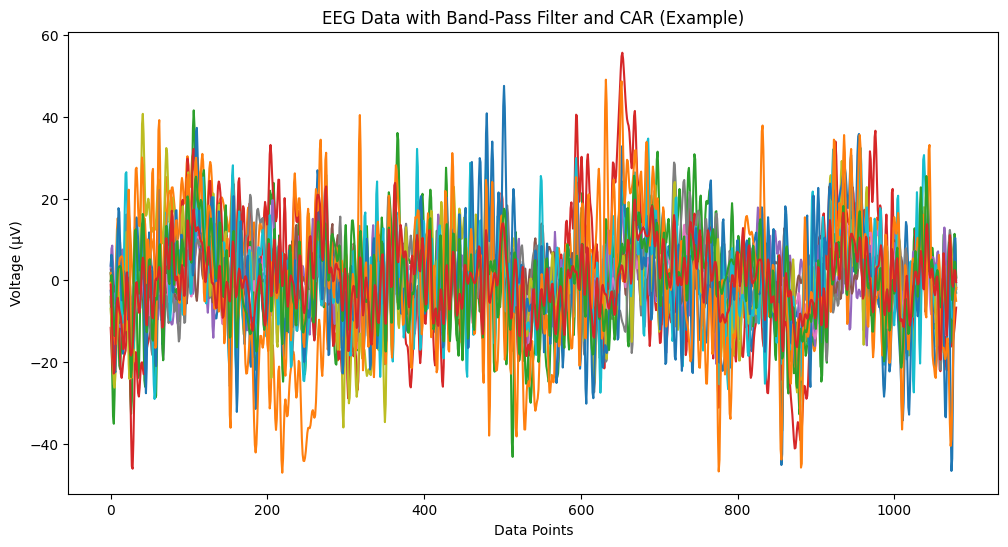

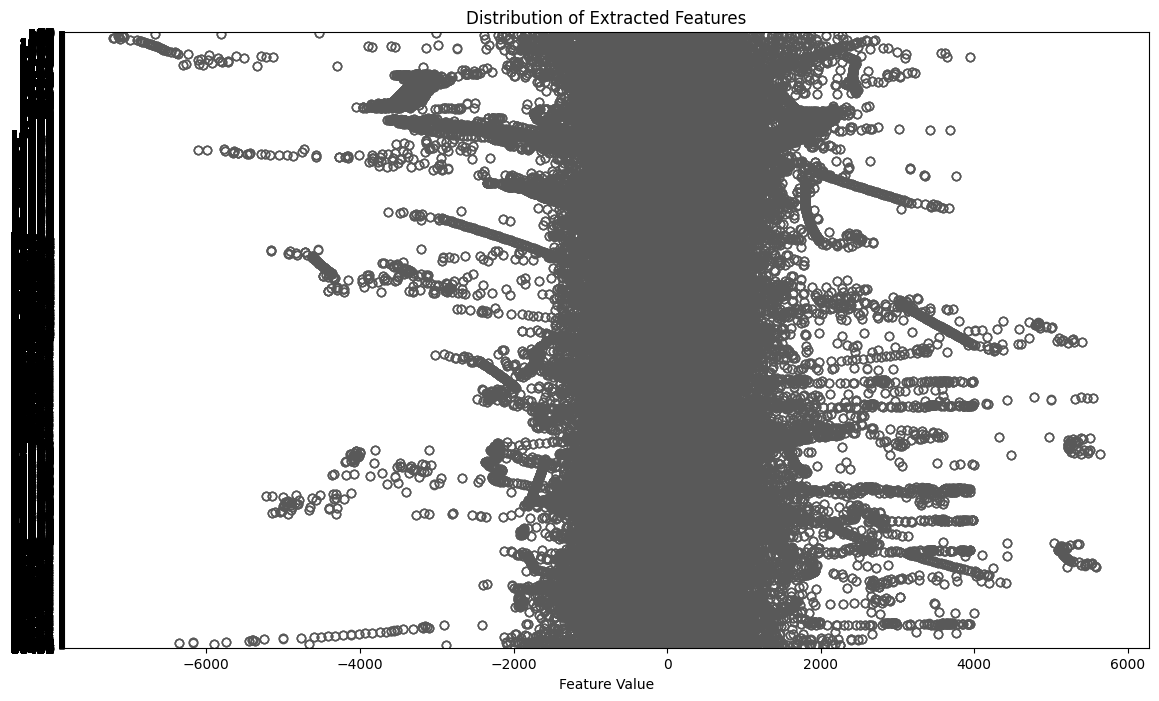

In [6]:

# Extract features
features = extract_features(flattened_EEG_data)

# Step 3: Data Visualization
# Visualize preprocessed data (First epoch)
plt.figure(figsize=(12, 6))
plt.plot(filtered_EEG_data[0][:, :256]) 
plt.title("EEG Data with Band-Pass Filter and CAR (Example)")
plt.xlabel("Data Points")
plt.ylabel("Voltage (µV)")
plt.show()

# Visualize feature distribution
plt.figure(figsize=(14, 8))
sns.boxplot(data=features, orient="h", palette="Set2")
plt.title("Distribution of Extracted Features")
plt.xlabel("Feature Value")
plt.show()

In [7]:
import pandas as pd

features_df = pd.DataFrame(features)

features_df.to_csv("_DATA/extracted_features.csv", index=False)

In [ ]:
print("Shape of filtered_EEG_data:", filtered_EEG_data.shape)
print("Shape of features:", features.shape)

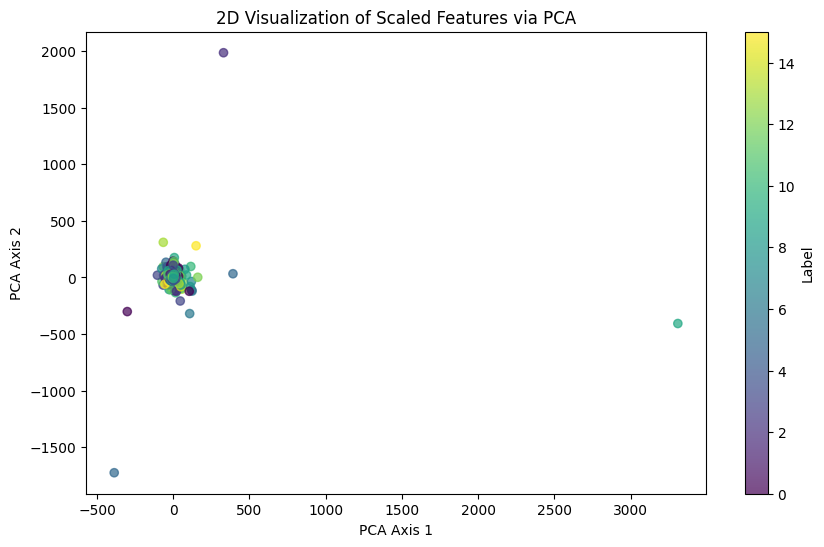

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=flattened_Labels, cmap="viridis", alpha=0.7)
plt.title("2D Visualization of Scaled Features via PCA")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.colorbar(label="Label")
plt.show()



In [19]:

# Step 4: Split data into training and testing sets
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, flattened_Labels, test_size=0.3, random_state=42)
print("Data split complete!")

# Step 5: Build and Train Classification Model Pipeline
print("Building and training classification model pipeline...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=30, random_state=42))
])

Splitting data into training and test sets...
Data split complete!
Building and training classification model pipeline...


In [20]:
# Train model
pipeline.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


In [21]:

# Step 6: Predict on test data
print("Predicting on test data...")
y_pred = pipeline.predict(X_test)
print("Prediction complete!")

Predicting on test data...
Prediction complete!


In [22]:
# Step 7: Evaluate model
print("Evaluating model...")
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[str(lbl) for lbl in label_to_int.keys()])

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Evaluating model...
Model Accuracy: 0.06030701754385965
Classification Report:
               precision    recall  f1-score   support

           f       0.06      0.10      0.07        61
      fleece       0.04      0.05      0.05        64
       goose       0.08      0.09      0.08        67
           k       0.04      0.05      0.05        56
           m       0.01      0.02      0.02        49
           n       0.11      0.12      0.11        59
          ng       0.06      0.07      0.07        54
           p       0.08      0.09      0.09        54
           s       0.05      0.05      0.05        56
          sh       0.03      0.02      0.02        61
           t       0.05      0.05      0.05        55
     thought       0.05      0.04      0.04        48
        trap       0.05      0.03      0.04        58
           v       0.05      0.03      0.04        61
           z       0.07      0.04      0.05        50
          zh       0.13      0.08      0.10        59

